<a href="https://colab.research.google.com/github/paulo-batista/puc-rio-ciencia-de-dados-e-analytics/blob/main/PauloBatista_MVP_PUCRIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **PUCRIO - MVP - Engenharia de dados**

##  1. Objetivo

Este MVP tem por objetivo desenvolvimento de pipelines de dados (batch and stream) para a disciplina de Data Engineering.

Estudo de caso:

Empresa de investimento XYZ gostaria de obter dados da corretora binance para automação de compra e venda de Bitcoin.

Para isso, será desenvolvido dois pipelines de dados, uma pipeline para treinamento e outro para inferencia.

O pipeline de treinamento, requer a coleta de dados históricos com o valor de fechamento ao longos dos anos.

O pipeline de inferência, recebe os dados com a velocidade de near-realtim (streaming) e deve utilizar armazenamento de velocidade rápida.

### 1.1 Arquitetura de treinamento

A figura abaixo tem a representação do pipeline de treinamento, que utiliza como método de ingestão a Binance API binance.client.historical_klines que irá carregar os dados históricos a realizar a tranformação, obtendo como resultado a tabela de treinamento.

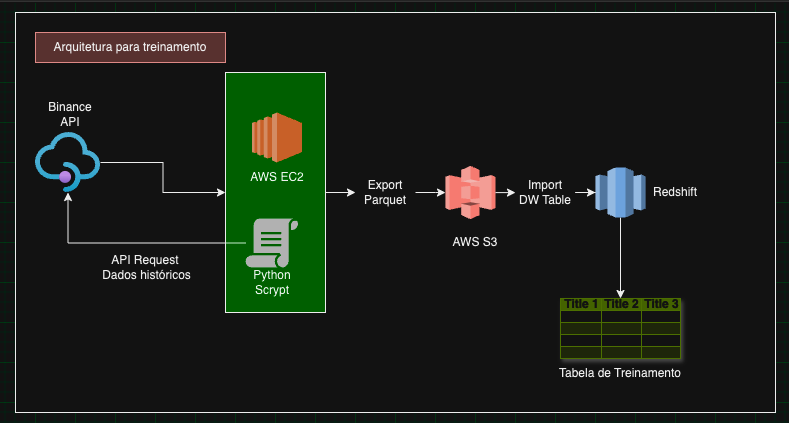

A figura abaixo tem a representação do pipeline de inferencia (streaming) , que utiliza como método de ingestão a Binance Websocket API que irá carregar os dados near realtime, via um python script bot.py, e depois o pipeline seguirá com a transformação, até resultar na tabela de inferëncia.

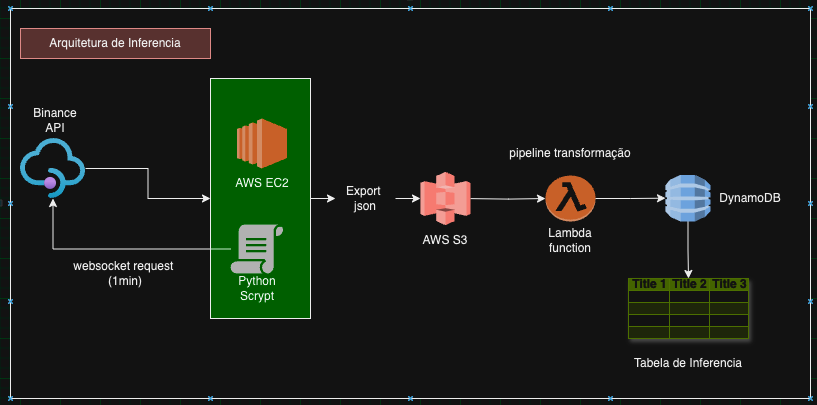

## 2. Coleta

### 2.1 - Coleta de dados históricos (Batch)

Código abaixo faz a requisição via Binance API, e armazena no formato parque. Que depois será importado manualmento no em um AWS S3 Bucket. Foi utilizado AWS EC2 (Maquina Virtual) com python para execução do script.

In [ ]:
import pandas as pd
from binance.client import Client
import numpy as np
import matplotlib.pyplot as plt

client = Client("", "", tld='us')
pd.options.mode.chained_assignment = None  # default='warn'

klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1MINUTE, "01 JAN, 2009", "31 DEC, 2024")
df= pd.DataFrame(klines)
df = pd.DataFrame (klines, columns = ['Timestamp', 'Open','High', 'Low', 'Close', 'Volume', 'CloseTime', 'QuoteAssetVolume', 'NumberOfTrades', 'TakerBuyBase', 'TakeBuyQuote', 'NotUsed'])
df.shape

def save_dataframe_in_chunks(dataframe, file_prefix, chunk_size, compression='snappy'):
    num_chunks = len(dataframe) // chunk_size + int(len(dataframe) % chunk_size != 0)
    for i in range(num_chunks):
        start_row = i * chunk_size
        end_row = (i + 1) * chunk_size
        chunk = dataframe[start_row:end_row]
        chunk.to_parquet(f'{file_prefix}_part_{i}.parquet', index=False, compression=compression)
        print(f'Saved {file_prefix}_part_{i}.parquet with {len(chunk)} rows.')


# Parameters
chunk_size = 100000  # Adjust based on your memory and performance requirements
file_prefix = 'btc_usdt_historical_data'

# Save the DataFrame in chunks
save_dataframe_in_chunks(df, file_prefix, chunk_size)

Saved btc_usdt_historical_data_part_0.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_1.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_2.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_3.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_4.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_5.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_6.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_7.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_8.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_9.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_10.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_11.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_12.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_13.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_14.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_15.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_16.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_17.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_18.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_19.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_20.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_21.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_22.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_23.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_24.parquet with 100000 rows.
Saved btc_usdt_historical_data_part_25.parquet with 19455 rows.

### 2.2 Coleta de dados streaming

Código abaixo faz a requisição via Binance Websocket API, e armazena no formato json. Que depois será importado manualmento no em um AWS S3 Bucket. Foi utilizado AWS EC2 (Maquina Virtual) com python para execução do script.

In [ ]:
import asyncio
import os
import boto3
import json
from binance import AsyncClient, BinanceSocketManager
from datetime import datetime

# AWS S3 setup
s3 = boto3.client('s3')
bucket_name = 'binance-streaming'

async def upload_to_s3(file_name, bucket_name, object_name=None):
    if object_name is None:
        object_name = file_name
    try:
        s3.upload_file(file_name, bucket_name, object_name)
        print(f"File {file_name} uploaded to S3 bucket {bucket_name} as {object_name}")
    except Exception as e:
        print(f"Failed to upload {file_name} to S3: {e}")

async def main():
    client = await AsyncClient.create(tld='us')
    bm = BinanceSocketManager(client)

    # start any sockets here, i.e a trade socket
    ts = bm.trade_socket('BTCUSDT')
    # then start receiving messages
    async with ts as tscm:
        while True:
            res = await tscm.recv()
            print(f"BTC price: \n{res}")

            # Save to file
            timestamp = datetime.utcnow().strftime('%Y%m%d%H%M%S%f')
            file_name = f"btc_trade_{timestamp}.json"
            with open(file_name, 'w') as f:
                json.dump(res, f)

            # Upload to S3
            await upload_to_s3(file_name, bucket_name)

            # Remove the local file after uploading
            os.remove(file_name)

    await client.close_connection()

if __name__ == "__main__":

    loop = asyncio.get_event_loop()
    loop.run_until_complete(main())

## 3. Carga

### 3.1 Carga dos dados em Batch

### 3.1.1 Carga Amazon S3

Os dados foram armazendos no bucket binance-batch formato parquet. Foi escolhido o parquet pelo ganho de performance e armazenagem de metadatos

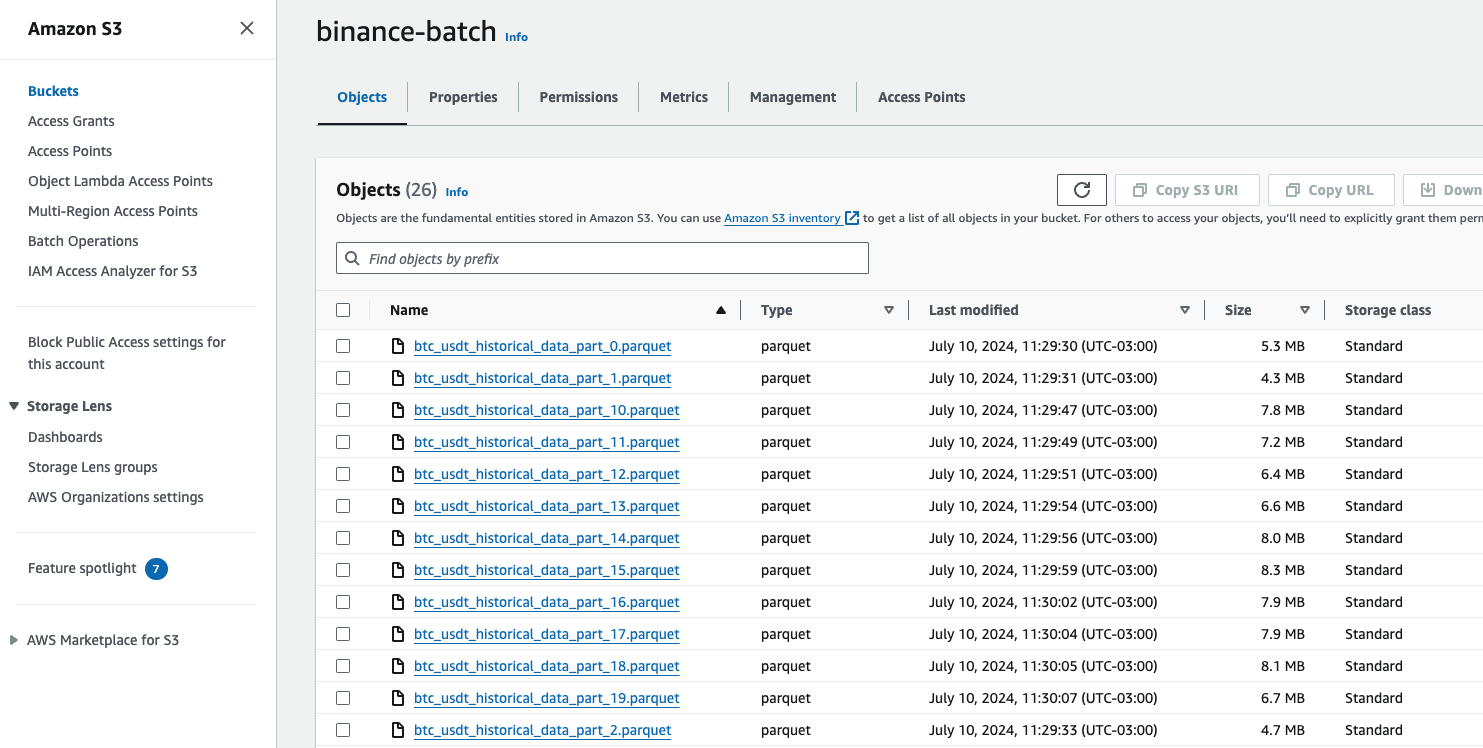

### 3.1.2 - Carga no DW, Amazon Redshift

Após a carga dos dados no S3, foi utilizado o DW da Amazon Redshift para importar dos dados dos arquivos parquet, e mantidos como os dados brutos, sem nenhuma transformação (RAW Data)

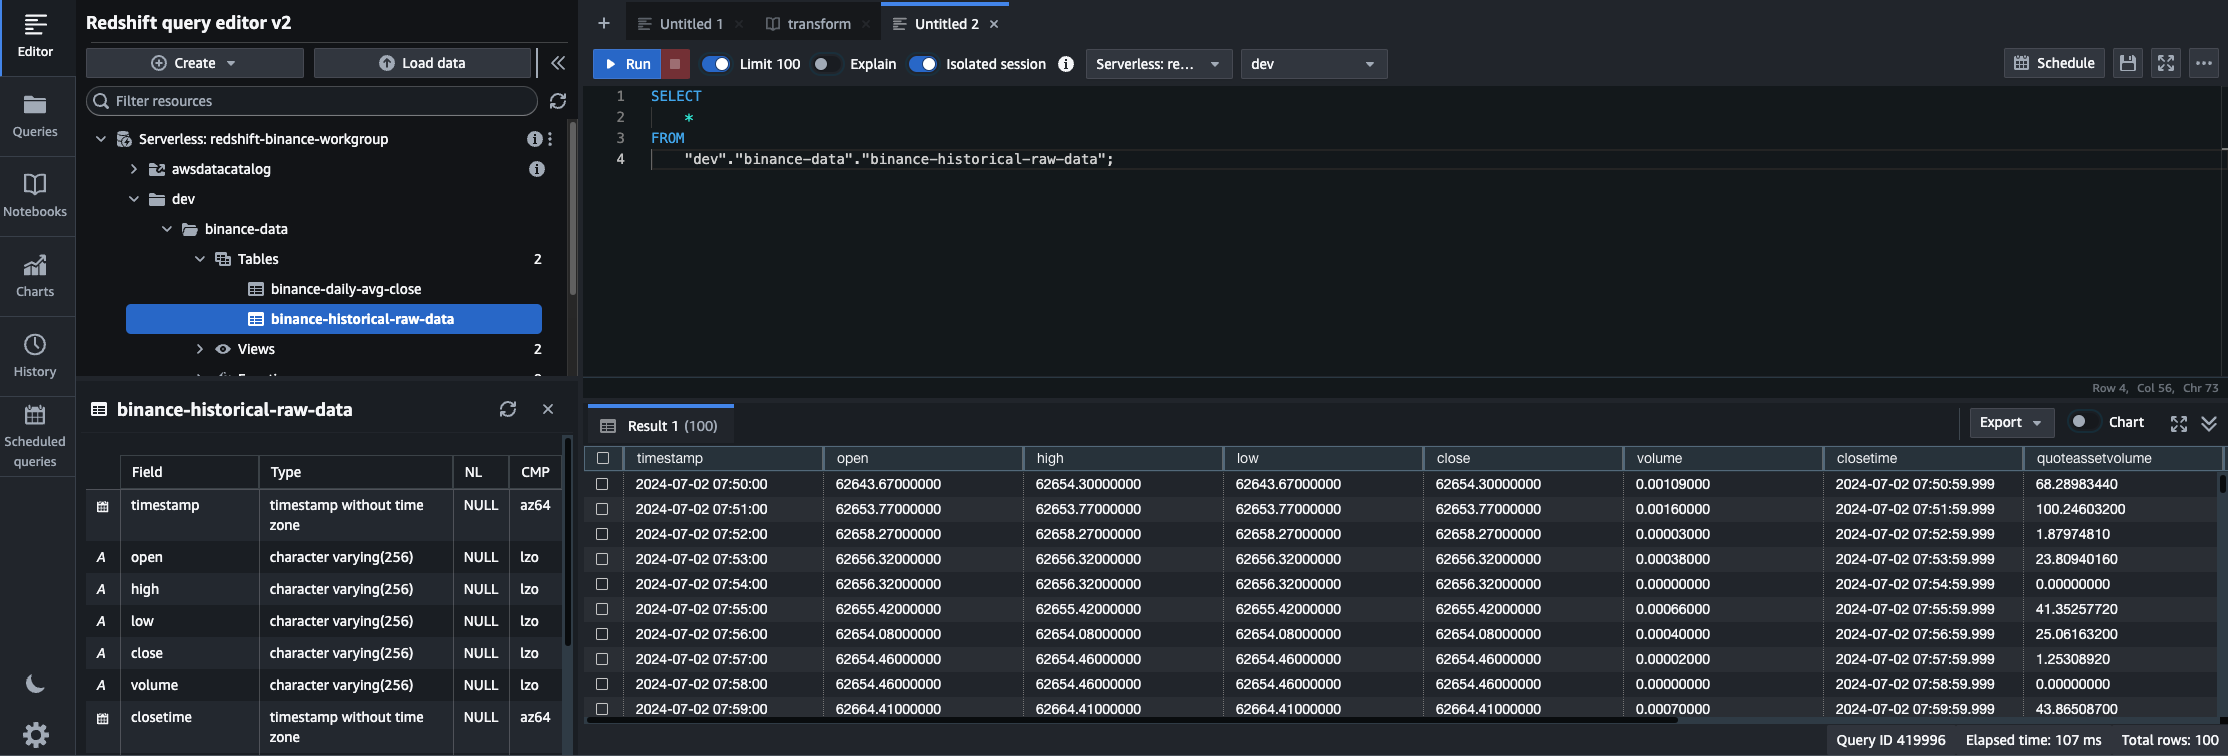

Aqui ocorre a transformação que irá gerar a tabela para treinamento de modelos.

In [ ]:
CREATE TABLE dev.binance_data.daily_avg_close AS
SELECT
    DATE(timestamp 'epoch' + "timestamp" * interval '1 second') as date,
    AVG("close"::float8) as close
FROM
    "binance-data"."binance-historical-raw-data"
GROUP BY
    DATE(timestamp 'epoch' + "timestamp" * interval '1 second')
ORDER BY
    date;

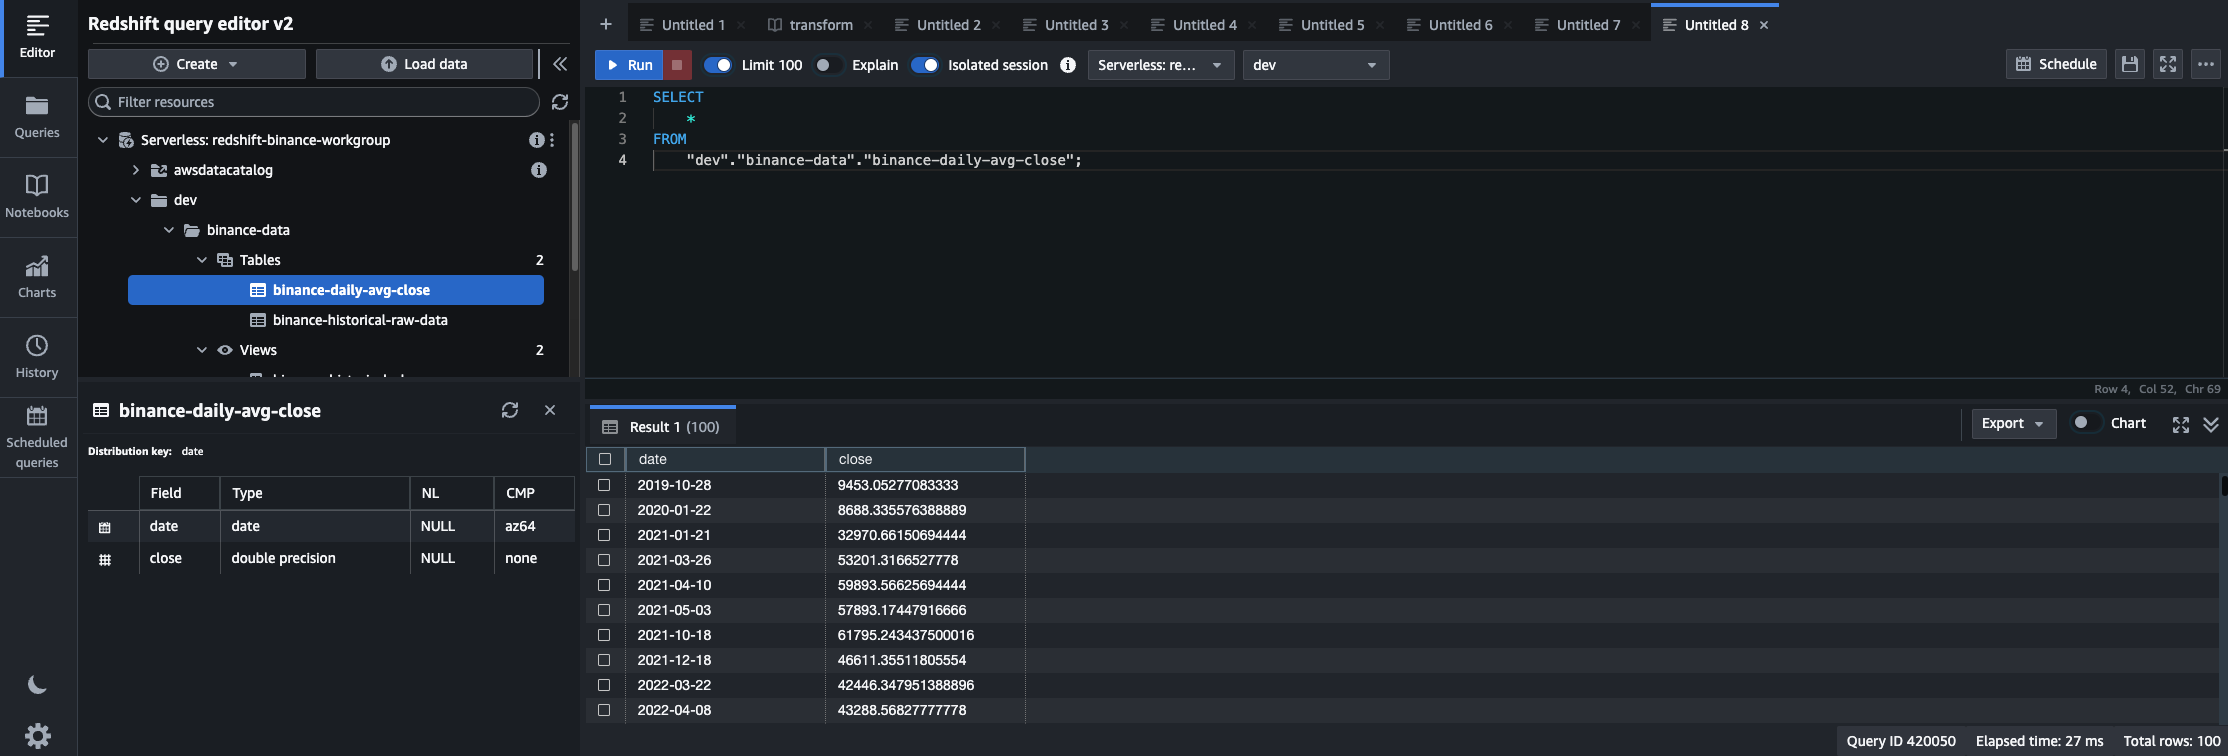

### 3.2 Carga de dados streaming

### 3.2.1 - Carga no Amazon S3

Os dados foram armazendos no bucket binance-batch formato Json. Estes dados serão automaticamento importados posteriomente no AMAZON DynamoDB, via Lambda Function

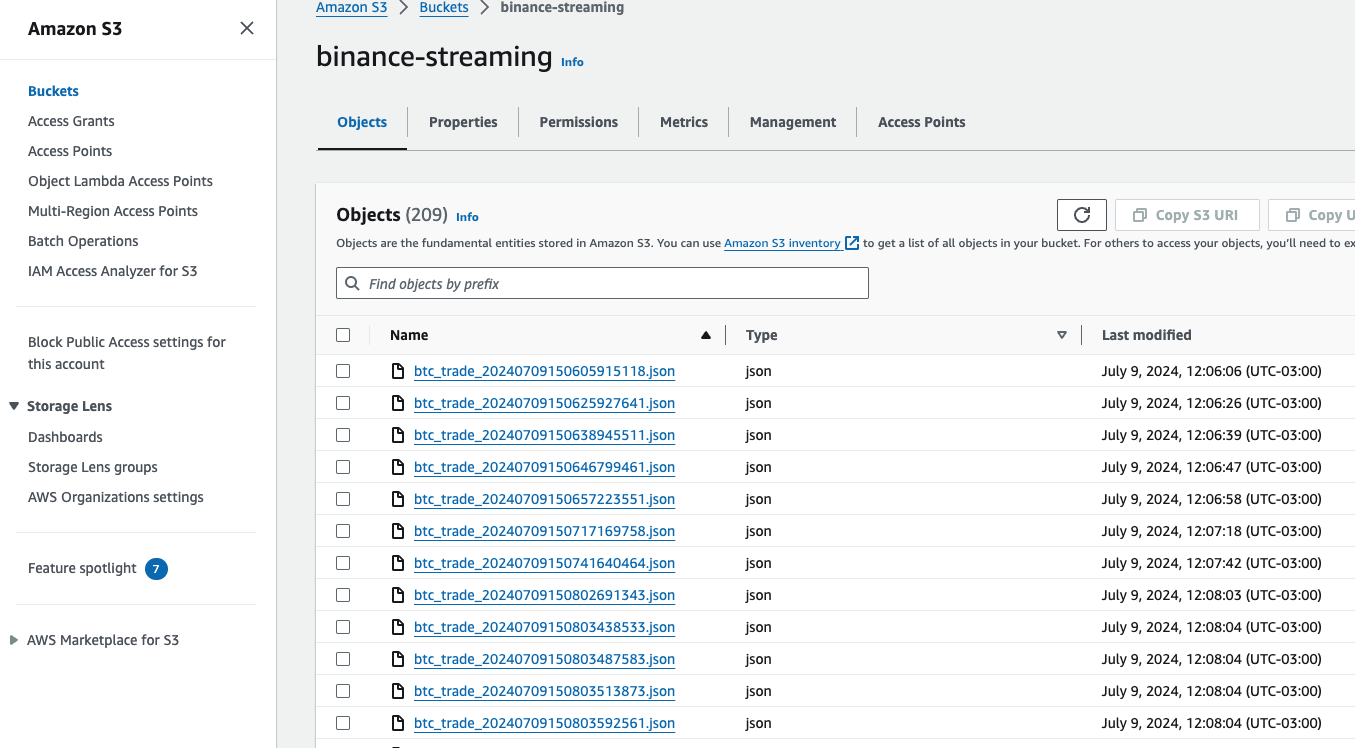

### 3.2.2 Lambda function, tranformation script

A funçao Lambda abaixo, importa os arquivos json para a tabela, binance_inferencedb.

In [ ]:
import json
import boto3

dynamodb = boto3.resource('dynamodb')
s3 = boto3.client('s3')

def lambda_handler(event, context):
    bucket = event['Records'][0]['s3']['bucket']['name']
    key = event['Records'][0]['s3']['object']['key']

    # Get the file from S3
    s3_response = s3.get_object(Bucket=bucket, Key=key)
    json_content = s3_response['Body'].read().decode('utf-8')
    items = json.loads(json_content)

    table = dynamodb.Table('binance_inferencedb')

    # Add each item to the DynamoDB table
    with table.batch_writer() as batch:
        for item in items:
            batch.put_item(Item=item)

    return {
        'statusCode': 200,
        'body': json.dumps('Successfully added items to DynamoDB')
    }

Os dados agora presente no DynamoDB estão prontos para serem utilizados pelos modelos para inferência em near-realtime. Aqui ocorrem as seguintes transformações:

*   Redução de dimensão dos dados originais
*   Conversão do timestamp para obter somente data
*   Mudança do formato do campo close de string para double-precision


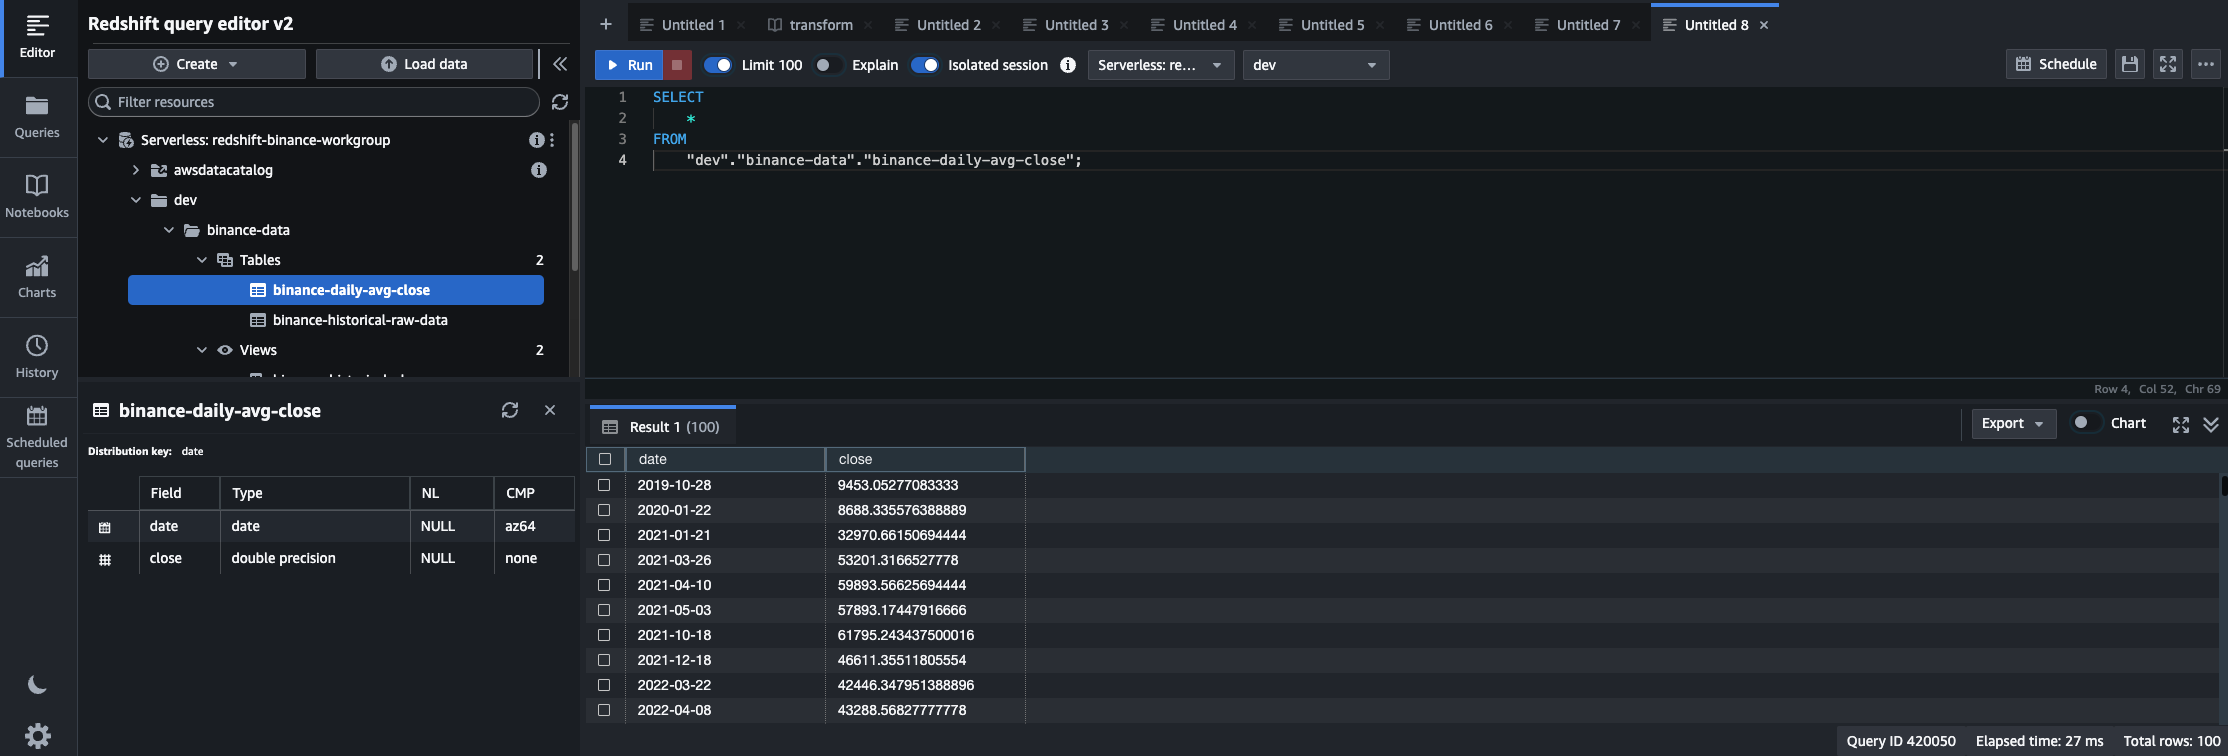

## 4. Análise

Formato de Metadados dos Dados Históricos de Klimes da Binance

	•	Open time (Hora de abertura): Tempo de abertura da vela em milissegundos desde a época (1970-01-01T00:00:00.000Z).
	•	Open (Preço de abertura): Preço de abertura da criptomoeda no início do intervalo de tempo.
	•	High (Preço mais alto): Preço mais alto da criptomoeda durante o intervalo de tempo.
	•	Low (Preço mais baixo): Preço mais baixo da criptomoeda durante o intervalo de tempo.
	•	Close (Preço de fechamento): Preço de fechamento da criptomoeda no final do intervalo de tempo.
	•	Volume: Volume de criptomoedas negociadas durante o intervalo de tempo.
	•	Close time (Hora de fechamento): Tempo de fechamento da vela em milissegundos desde a época (1970-01-01T00:00:00.000Z).
	•	Quote asset volume (Volume do ativo cotado): Volume do ativo cotado negociado durante o intervalo de tempo.
	•	Number of trades (Número de negociações): Número de negociações executadas durante o intervalo de tempo.
	•	Taker buy base asset volume (Volume do ativo base comprado pelos takers): Volume do ativo base comprado por takers durante o intervalo de tempo.
	•	Taker buy quote asset volume (Volume do ativo cotado comprado pelos takers): Volume do ativo cotado comprado por takers durante o intervalo de tempo.

Um exemplo de como esses metadados podem ser estruturados em uma lista:

In [ ]:
[
    1499040000000,      # Hora de abertura
    "0.01634790",       # Preço de abertura
    "0.80000000",       # Preço mais alto
    "0.01575800",       # Preço mais baixo
    "0.01577100",       # Preço de fechamento
    "148976.11427815",  # Volume
    1499644799999,      # Hora de fechamento
    "2434.19055334",    # Volume do ativo cotado
    308,                # Número de negociações
    "1756.87402397",    # Volume do ativo base comprado pelos takers
    "28.46694368"       # Volume do ativo cotado comprado pelos takers
]

## 5. Autoavaliação

Procurei utilizar neste MVP todos os elementos aprendidos durante o curso. Desde modelos de ingestão com velocidades diferentes (batch e stream), e diferentes modelos de armazenamento, como armazenamento em cloud, DW e NOSQL databases.

Foi uma experiência bem interessante toda a construção do cenário.